In [10]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
f = pd.read_csv('spam.csv')
f.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Handeling Imbalance data set

In [4]:
f.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [6]:
f['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

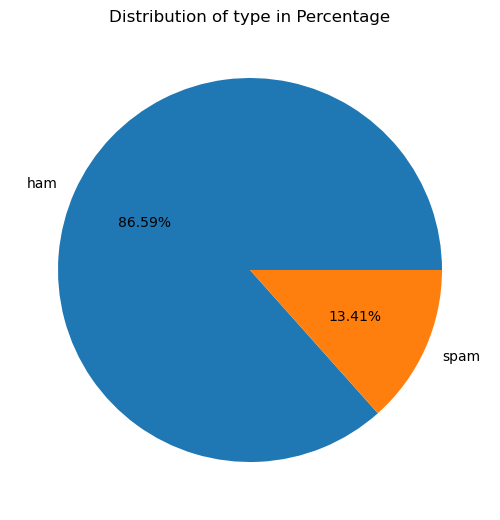

In [11]:
pie = f['Category'].value_counts().rename_axis('Subclass').reset_index(name = 'counts')
labels = pie.Subclass
values = pie.counts
# explode = [0.1,0,0]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.pie(values, labels = labels, autopct = '%1.2f%%')
plt.title("Distribution of type in Percentage")
plt.show()

In [13]:
df_spam = f[f['Category']=='spam']
df_spam.shape

(747, 2)

In [14]:
df_ham = f[f['Category']=='ham']
df_ham.shape

(4825, 2)

In [15]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [16]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 2)

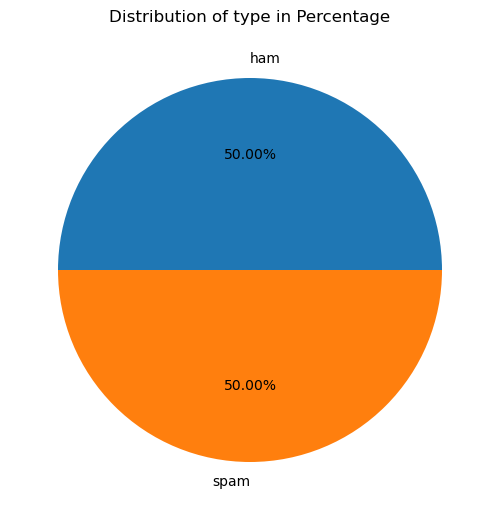

In [17]:
pie = df_balanced['Category'].value_counts().rename_axis('Subclass').reset_index(name = 'counts')
labels = pie.Subclass
values = pie.counts
# explode = [0.1,0,0]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.pie(values, labels = labels, autopct = '%1.2f%%')
plt.title("Distribution of type in Percentage")
plt.show()

In [18]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)


,Category,Message,spam
2752,ham,Play w computer? Aiyah i tok 2 u lor?,0
3433,spam,Camera - You are awarded a SiPix Digital Camer...,1
3023,ham,How dare you change my ring,0
4768,spam,Your unique user ID is 1172. For removal send ...,1
1745,spam,Someone has conacted our dating service and en...,1


## Train Test Split

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

## Bert For Embeddings

In [20]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [21]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)


<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.843517  , -0.5132726 , -0.8884572 , ..., -0.74748856,
        -0.7531473 ,  0.91964483],
       [-0.8720835 , -0.50543964, -0.94446677, ..., -0.8584752 ,
        -0.7174535 ,  0.8808299 ]], dtype=float32)>

## Training the Dataset

In [22]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [24]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [25]:
model.fit(X_train, y_train, epochs=10)


Epoch 1/10
35/35 [==============================] - 290s 8s/step - loss: 0.6480 - accuracy: 0.6116 - precision: 0.6177 - recall: 0.5857
Epoch 2/10
35/35 [==============================] - 269s 8s/step - loss: 0.5194 - accuracy: 0.8080 - precision: 0.7990 - recall: 0.8232
Epoch 3/10
35/35 [==============================] - 289s 8s/step - loss: 0.4446 - accuracy: 0.8509 - precision: 0.8453 - recall: 0.8589
Epoch 4/10
35/35 [==============================] - 312s 9s/step - loss: 0.3889 - accuracy: 0.8813 - precision: 0.8637 - recall: 0.9054
Epoch 5/10
35/35 [==============================] - 322s 9s/step - loss: 0.3611 - accuracy: 0.8830 - precision: 0.8629 - recall: 0.9107
Epoch 6/10
35/35 [==============================] - 315s 9s/step - loss: 0.3414 - accuracy: 0.8857 - precision: 0.8649 - recall: 0.9143
Epoch 7/10
35/35 [==============================] - 310s 9s/step - loss: 0.3146 - accuracy: 0.8920 - precision: 0.8752 - recall: 0.9143
Epoch 8/10
35/35 [==============================

## Model Evaluation

In [26]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 102s 8s/step - loss: 0.3106 - accuracy: 0.8797 - precision: 0.8901 - recall: 0.8663


[0.31059589982032776,
 0.8796791434288025,
 0.8901098966598511,
 0.866310179233551]

In [27]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten() 

12/12 [==============================] - 99s 8s/step


In [28]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1,

In [29]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[167,  20],
       [ 25, 162]], dtype=int64)

Text(50.722222222222214, 0.5, 'Truth')

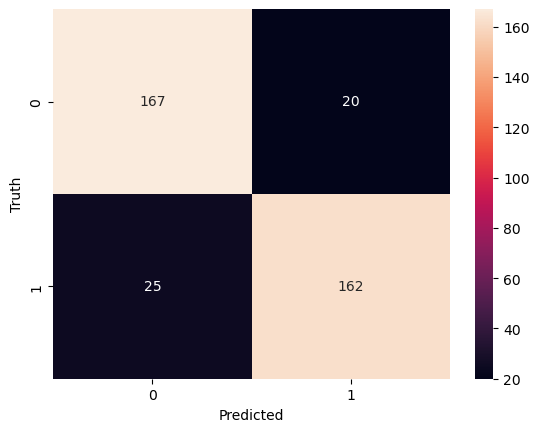

In [30]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [31]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88       187
           1       0.89      0.87      0.88       187

    accuracy                           0.88       374
   macro avg       0.88      0.88      0.88       374
weighted avg       0.88      0.88      0.88       374



In [32]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 3s 3s/step


array([[0.71307606],
       [0.81562525],
       [0.75339985],
       [0.1955813 ],
       [0.08020217]], dtype=float32)